# Import

In [49]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import copy

import pickle
from datetime import datetime

import scipy.stats as ss
from scipy.stats import norm
from scipy.stats import poisson
from scipy import spatial

# import code
from simulation import Simulation
from replicate_graph import layer_graph
import data
from data import select_dataset, get_station_g, set_random_speed_columns
from visualization import set_draw_attributes

import os

import re
from tqdm import tqdm

# Simulation

Intialize the simulation with basic parameters.

In [3]:
simulation_length = 12
battery_interval = 20
km_per_percent = 3.13
stations_path = "data/wcctci_stations-updated.csv"
distances_path = "data/wcctci_coord_distances.csv"
sim = Simulation("wcctci", stations_path, distances_path, simulation_length, battery_interval, km_per_percent)
sim.add_demand_nodes()

In [ ]:
sim.run()

In [ ]:
for v in sim.vehicle_list:
    print(v.path)

In [ ]:
for v in sim.vehicle_list:
    print(v.location, ":", v.distance_along_segment)

In [ ]:
sim.battery_G
labels = {node:node[-2:] if "in" in node else node[-3:] for node in list(sim.battery_G.nodes)}
pos, edge_colors = set_draw_attributes(sim.battery_G, station_G)
edge_labels = nx.get_edge_attributes(sim.battery_G,'weight')
nx.draw(sim.battery_G, pos = pos, labels = labels, edge_color = list(edge_colors.values()), 
        font_size = 8, font_color="white", node_color="black")
nx.draw_networkx_edge_labels(sim.battery_G, pos, edge_labels=edge_labels)

# Animation
TODO

# Visualize general data structure

In [ ]:
# print(list(stations_df["OID_"]))
# print(station_G.nodes)
stations_df.head(1)

In [ ]:
# Set colors
for node in station_G.nodes:
    station_G.nodes[node]["color"] = "green"
    station_G.nodes[node]["node_size"] = 400
    
station_G.nodes["465"]["color"] = "blue" 
station_G.nodes["1"]["color"] = "blue" 
station_G.nodes["465"]["node_size"] = 400 
station_G.nodes["1"]["node_size"] = 400 

In [ ]:
pos=nx.get_node_attributes(station_G,'pos')
color = nx.get_node_attributes(station_G,'color').values()
node_size = list(nx.get_node_attributes(station_G,'node_size').values())
labels = {node:node for node in list(station_G.nodes)}
nx.draw(station_G, pos = pos, node_size=node_size, width=.5, node_color=color, labels = labels, 
        font_color = "white", font_size = 10)

In [ ]:
labels = {node:node[-2:] if "in" in node else node[-3:] for node in list(G.nodes)}
pos, edge_colors = set_draw_attributes(G, station_G)
edge_labels = nx.get_edge_attributes(G,'weight')
nx.draw(G, pos = pos, labels = labels, edge_color = list(edge_colors.values()), 
        font_size = 8, font_color="white", node_color="black")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

 # Results analysis 

In [122]:
with open('trials/wcctci_updated_paths_04_14_2022_10_34_09.pkl', 'rb') as inp:
    res = pickle.load(inp)
    
locations = np.full((len(res.vehicle_list),int(res.simulation_length/res.time_interval+1)), fill_value="").tolist()
for row, vehicle in enumerate(res.vehicle_list):
    i = vehicle.start_time
    j = vehicle.start_time + len(vehicle.locations)+1
    str_locations = [loc[0]+":"+loc[1] for loc in vehicle.locations]
    locations[row][i:j] = str_locations

In [126]:
np_locations = np.array(locations)

In [144]:
def get_edge_totals(arr):
    edges={}
    for entry in arr:
        loc = entry.split(":")
        src = loc[0].split("_")[0]
        try:
            dst = loc[1].split("_")[0]
        except:
            dst = src
        if (src, dst) in edges:
            edges[(src, dst)]+=1
        else:
            edges[(src, dst)]=0
    return edges

edge_totals = np.apply_along_axis(get_edge_totals, 1, np_locations.T)

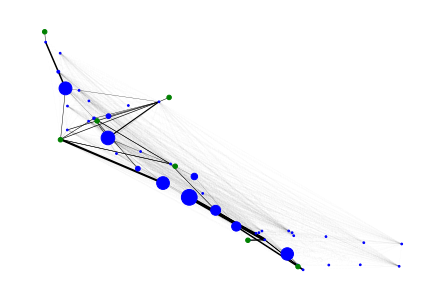

In [199]:
G = res.station_demand_g
sim_index = 50
#colors
for node in G.nodes:
    G.nodes[node]["color"] = "blue"
    G.nodes[node]["size"] = 3
for node in nx.get_node_attributes(G,'demand'):
    G.nodes[node]["color"] = "green"
    G.nodes[node]["size"] = 20
node_color = nx.get_node_attributes(G,'color').values() 
node_size = {node: edge_totals[sim_index][(node, node)] if (node, node) in edge_totals[sim_index] else G.nodes[node]["size"] for node in G.nodes}
widths = {edge:edge_totals[sim_index][edge]/100 if edge in edge_totals[sim_index] else .002 for edge in G.edges}
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos = pos, node_size = list(node_size.values()), width= list(widths.values()), node_color=node_color, arrows=False)